In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
import pickle
import pandas as pd
import glob, os, gc
from sklearn.decomposition import PCA
from tqdm import tqdm
from sklearn.model_selection import KFold

# Add the path to the directory containing the module
import sys
sys.path.append('../../')
from util.ml import baseline, metrics, nestedMLR

from properscoring import crps_ensemble  # For CRPS calculation
from sklearn.utils import resample  # For bootstrapping

In [3]:
# Find the folder name organized by seed number
seed_doc = sorted(glob.glob('../../datas/seed_revised_*/'))[0]

# Load the data
# Load the time series data
df = pd.read_csv(seed_doc +'X_train_ts_all.csv')
df_valid = pd.read_csv(seed_doc +'X_validation_ts_all.csv')
df_test = pd.read_csv(seed_doc +'X_test_ts_all.csv')

# Find the name for each column
column_names = ([obj.split('_step_')[0] for obj in df.columns])
# Unique names in the column name list
unique_names = list(set(column_names))
# Remove strings with large_scale
unique_names_filt = [var for var in unique_names if "large_scale" not in var]

# Now we read in the y data for every fold
y_train = []
y_val = []
for i in range(7):
    y_train.append(baseline.load_pickle(f'../../datas/proc/sfs/y/ytrain_split_{i}.pkl'))
    y_val.append(baseline.load_pickle(f'../../datas/proc/sfs/y/yval_split_{i}.pkl'))

pcs_train = baseline.load_pickle(f'../../datas/proc/sfs/pcsall_train.pkl')
pcs_val = baseline.load_pickle(f'../../datas/proc/sfs/pcsall_valid.pkl')

In [18]:
expttype = 'max'
filted_feature = baseline.load_pickle(f'../../datas/proc/sfs/results/best_linear_{expttype}_feature.pkl')

In [13]:
from natsort import natsorted
def r2_score_f(y_true,y_pred):
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()

    r2 = 1-np.sum((y_true-y_pred)**2)/np.sum((y_true-np.mean(y_true))**2)
    return r2

def select_subset_X(pcs_train,pcs_val,y_train,iseed,selected_pcs,pcnum):
    X_train_subset = [pcs_train[iseed][sel_var][:,:pcnum] for sel_var, _ in selected_pcs]
    X_val_subset = [pcs_val[iseed][sel_var][:,:pcnum] for sel_var, _ in selected_pcs]
    return X_train_subset, X_val_subset

In [19]:
X_train_subset, X_val_subset = [],[]
for i in range(7):
    X_train, X_val = select_subset_X(pcs_train,pcs_val,y_train,i,filted_feature,3)
    X_train_subset.append(X_train)
    X_val_subset.append(X_val)
sizes = [obj.shape[1] for obj in X_train_subset[0]]

In [16]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
store_stats = []
for j in range(7):
    models, val_rmses, train_rmses, val_r2, train_r2 = [],[],[],[],[]
    for i in tqdm(range(1, 3)):#5)):
        #model = nestedMLR.nestedMLR_var_global(sizes[:i],4, 3)
        model = nestedMLR.nestedMLR_var_global_l1l2(sizes[:i],1, 5, 'l2', 0.25)
        #model = nestedMLR.nestedMLR_VED(sizes[:i], [int(obj) for obj in np.ones(len(sizes))][:i], seed=3, bounds=2, reg_type='L2', reg_coeff=0)
        model.fit(np.hstack(X_train_subset[j][:i]), y_train[j][expttype],  1000)
        models.append(model)
        y_trainpred = model.predict(np.hstack(X_train_subset[j][:i]))
        y_valpred = model.predict(np.hstack(X_val_subset[j][:i]))
        val_rmses.append(mean_squared_error(y_val[j][expttype], y_valpred, squared=False))
        train_rmses.append(mean_squared_error(y_train[j][expttype], y_trainpred, squared=False))
        val_r2.append(r2_score_f(y_val[j][expttype], y_valpred))
        train_r2.append(r2_score_f(y_train[j][expttype], y_trainpred))
    store_stats.append({'model': models, 'val_rmses': val_rmses, 'train_rmses': train_rmses, 'val_r2': val_r2, 'train_r2': train_r2})
    print(val_r2)

100%|██████████| 2/2 [00:24<00:00, 12.28s/it]


[0.4934364096348769, 0.5397645104994464]


100%|██████████| 2/2 [00:22<00:00, 11.46s/it]


[0.18847610914587598, 0.2717433207212825]


100%|██████████| 2/2 [00:23<00:00, 11.63s/it]


[0.5415446267823, 0.6150203120563247]


100%|██████████| 2/2 [00:23<00:00, 11.84s/it]


[0.1448350198208077, 0.27926103422874893]


100%|██████████| 2/2 [00:23<00:00, 11.61s/it]


[0.40933869328532235, 0.5419632775947687]


100%|██████████| 2/2 [00:23<00:00, 11.62s/it]


[0.3976801064501555, 0.4299590380402124]


100%|██████████| 2/2 [00:23<00:00, 11.53s/it]

[0.4883898102729458, 0.5234263725927653]


original

In [21]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
store_stats = []
for j in range(7):
    models, val_rmses, train_rmses, val_r2, train_r2 = [],[],[],[],[]
    for i in tqdm(range(1, 3)):#5)):
        #model = nestedMLR.nestedMLR_var_global(sizes[:i],4, 3)
        model = nestedMLR.nestedMLR_var_global_l1l2(sizes[:i],1, 5, 'l2', 0.25)
        #model = nestedMLR.nestedMLR_VED(sizes[:i], [int(obj) for obj in np.ones(len(sizes))][:i], seed=3, bounds=2, reg_type='L2', reg_coeff=0)
        model.fit(np.hstack(X_train_subset[j][:i]), y_train[j][expttype],  1000)
        models.append(model)
        y_trainpred = model.predict(np.hstack(X_train_subset[j][:i]))
        y_valpred = model.predict(np.hstack(X_val_subset[j][:i]))
        val_rmses.append(mean_squared_error(y_val[j][expttype], y_valpred, squared=False))
        train_rmses.append(mean_squared_error(y_train[j][expttype], y_trainpred, squared=False))
        val_r2.append(r2_score_f(y_val[j][expttype], y_valpred))
        train_r2.append(r2_score_f(y_train[j][expttype], y_trainpred))
    store_stats.append({'model': models, 'val_rmses': val_rmses, 'train_rmses': train_rmses, 'val_r2': val_r2, 'train_r2': train_r2})
    print(val_rmses)

100%|██████████| 2/2 [00:24<00:00, 12.23s/it]


[5.359511476718918, 4.983625942535455]


100%|██████████| 2/2 [00:24<00:00, 12.47s/it]


[9.627157625015142, 7.225443740369043]


100%|██████████| 2/2 [00:24<00:00, 12.36s/it]


[5.061575737954258, 4.5300223276697]


100%|██████████| 2/2 [00:22<00:00, 11.49s/it]


[7.306206567147703, 7.0372558164517285]


100%|██████████| 2/2 [00:22<00:00, 11.44s/it]


[5.601135951886359, 5.353565925962816]


100%|██████████| 2/2 [00:25<00:00, 12.68s/it]


[6.609511317657263, 5.8037772941505805]


100%|██████████| 2/2 [00:24<00:00, 12.14s/it]

[5.447083429488286, 4.60018468016517]


In [23]:
np.mean(np.asarray([obj['val_rmses'] for obj in store_stats]),axis=0)

array([6.43031173, 5.64769653])

In [14]:
indivi_PC = [5.505324926608202,5.408038070282172,5.343317324471862,5.28393796258513]

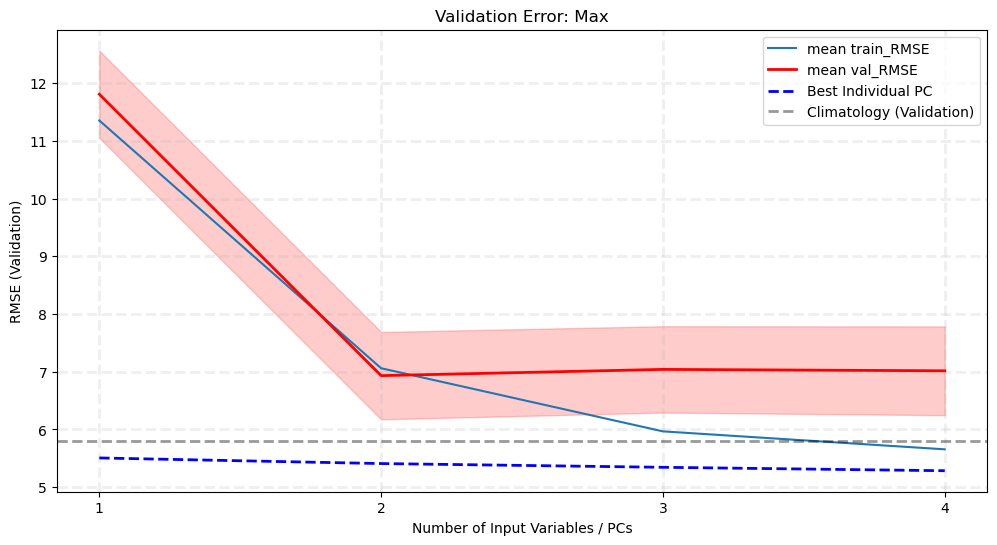

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(12,6))
ax.plot(np.arange(1, 5, 1),np.mean([np.asarray([obj['train_rmses'][i] for obj in store_stats]) for i in range(4)],axis=1),label='mean train_RMSE')
ax.plot(np.arange(1, 5, 1),np.mean([np.asarray([obj['val_rmses'][i] for obj in store_stats]) for i in range(4)],axis=1),label='mean val_RMSE',lw=2,c='r')
plt.fill_between(np.arange(1, 5, 1),np.asarray([np.asarray([obj['val_rmses'][i] for obj in store_stats]) for i in range(4)]).mean(axis=1)+np.asarray([np.asarray([obj['val_rmses'][i] for obj in store_stats]) for i in range(4)]).std(axis=1),
                    np.asarray([np.asarray([obj['val_rmses'][i] for obj in store_stats]) for i in range(4)]).mean(axis=1)-np.asarray([np.asarray([obj['val_rmses'][i] for obj in store_stats]) for i in range(4)]).std(axis=1),color='r',alpha=0.2)
ax.plot(np.arange(1, 5, 1), indivi_PC, color='b', linestyle='--',lw=2,label='Best Individual PC')
# Add horizontal line to show the RMSE of climatology
plt.axhline(y=5.804041392297193, color='k', linestyle='--',lw=2,label='Climatology (Validation)',alpha=0.4)
#plt.axhline(y=1.3538811982541485, color='k', linestyle='-',lw=2,label='Climatology (Train)',alpha=0.4)
#plt.axhline(y=1.13, color='b', linestyle='--',lw=2,label='Best Individual PC')
plt.legend()
# Customize x axis ticks
plt.xticks(np.arange(1, 5, 1))
plt.xlabel('Number of Input Variables / PCs')
plt.ylabel('RMSE (Validation)')
plt.title('Validation Error: Max')
plt.grid(lw=2,alpha=0.2,ls='--')
plt.show()

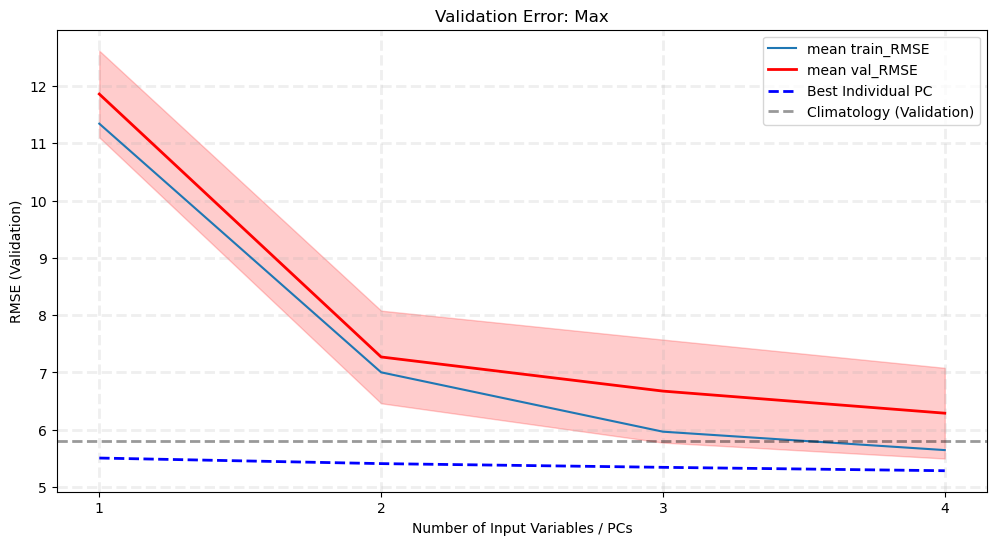

In [ ]:
# L1_0.1
fig,ax = plt.subplots(1,1,figsize=(12,6))
ax.plot(np.arange(1, 5, 1),np.mean([np.asarray([obj['train_rmses'][i] for obj in store_stats]) for i in range(4)],axis=1),label='mean train_RMSE')
ax.plot(np.arange(1, 5, 1),np.mean([np.asarray([obj['val_rmses'][i] for obj in store_stats]) for i in range(4)],axis=1),label='mean val_RMSE',lw=2,c='r')
plt.fill_between(np.arange(1, 5, 1),np.asarray([np.asarray([obj['val_rmses'][i] for obj in store_stats]) for i in range(4)]).mean(axis=1)+np.asarray([np.asarray([obj['val_rmses'][i] for obj in store_stats]) for i in range(4)]).std(axis=1),
                    np.asarray([np.asarray([obj['val_rmses'][i] for obj in store_stats]) for i in range(4)]).mean(axis=1)-np.asarray([np.asarray([obj['val_rmses'][i] for obj in store_stats]) for i in range(4)]).std(axis=1),color='r',alpha=0.2)
ax.plot(np.arange(1, 5, 1), indivi_PC, color='b', linestyle='--',lw=2,label='Best Individual PC')
# Add horizontal line to show the RMSE of climatology
plt.axhline(y=5.804041392297193, color='k', linestyle='--',lw=2,label='Climatology (Validation)',alpha=0.4)
#plt.axhline(y=1.3538811982541485, color='k', linestyle='-',lw=2,label='Climatology (Train)',alpha=0.4)
#plt.axhline(y=1.13, color='b', linestyle='--',lw=2,label='Best Individual PC')
plt.legend()
# Customize x axis ticks
plt.xticks(np.arange(1, 5, 1))
plt.xlabel('Number of Input Variables / PCs')
plt.ylabel('RMSE (Validation)')
plt.title('Validation Error: Max')
plt.grid(lw=2,alpha=0.2,ls='--')
plt.show()